In [1]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Load VGG-16 model pretrained on ImageNet dataset
model = vgg16.VGG16(weights='imagenet')

40960/35363 [==================================] - 0s 5us/step
Predicted: [('n02007558', 'flamingo', 0.9999957), ('n02006656', 'spoonbill', 1.854461e-06), ('n02009912', 'American_egret', 8.5071997e-07)]


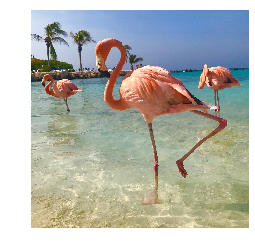

In [3]:
img_path = 'flamingo.jpg'
img = image.load_img(img_path, target_size=(224,224))

plt.imshow(img)
plt.grid('off')
plt.axis('off')

# Create a batch and preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

# Get the initial predictions
preds = model.predict(x)
initial_class = np.argmax(preds)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

In [0]:
# Inverse of the preprocessing and plot the image
def plot_img(x):
    """
    x is a BGR image with shape (? ,224, 224, 3) 
    """
    t = np.zeros_like(x[0])
    t[:,:,0] = x[0][:,:,2]
    t[:,:,1] = x[0][:,:,1]
    t[:,:,2] = x[0][:,:,0]  
    plt.imshow(np.clip((t+[123.68, 116.779, 103.939]), 0, 255)/255)
    plt.grid('off')
    plt.axis('off')
    plt.show()

# Sanity Check
# plot_img(x)

In [0]:
# Get current session (assuming tf backend)
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x
# Added noise
x_noise = np.zeros_like(x)

0 0.99999523 [('n02007558', 'flamingo', 0.99999523), ('n02006656', 'spoonbill', 2.0940704e-06), ('n02009912', 'American_egret', 9.710816e-07)]
20 0.99994767 [('n02007558', 'flamingo', 0.99994767), ('n02006656', 'spoonbill', 1.961062e-05), ('n02009912', 'American_egret', 1.08509075e-05)]
40 0.9996332 [('n02007558', 'flamingo', 0.9996332), ('n02006656', 'spoonbill', 0.000118419666), ('n02009912', 'American_egret', 7.331594e-05)]
60 0.99811816 [('n02007558', 'flamingo', 0.99811816), ('n02006656', 'spoonbill', 0.0005140035), ('n02009912', 'American_egret', 0.00035199756)]
80 0.992397 [('n02007558', 'flamingo', 0.992397), ('n02006656', 'spoonbill', 0.0017014656), ('n02009912', 'American_egret', 0.0012524195)]
100 0.9763466 [('n02007558', 'flamingo', 0.9763466), ('n02006656', 'spoonbill', 0.0043751663), ('n02012849', 'crane', 0.0034782344)]
120 0.93764275 [('n02007558', 'flamingo', 0.93764275), ('n02006656', 'spoonbill', 0.009315299), ('n02012849', 'crane', 0.008359682)]
140 0.85389864 [('n0

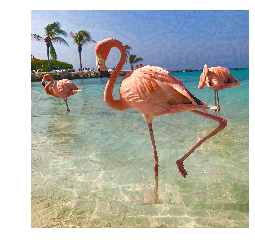

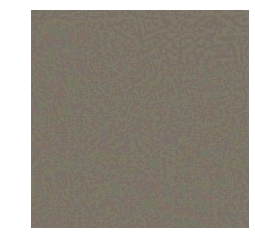

In [6]:
# Set variables
epochs = 400
epsilon = 0.01
prev_probs = []

for i in range(epochs): 
    # One hot encode the initial class
    target = K.one_hot(initial_class, 1000)
    
    # Get the loss and gradient of the loss wrt the inputs
    loss = K.categorical_crossentropy(target, model.output)
    grads = K.gradients(loss, model.input)

    # Get the sign of the gradient
    delta = K.sign(grads[0])
    x_noise = x_noise + delta

    # Perturb the image
    x_adv = x_adv + epsilon*delta

    # Get the new image and predictions
    x_adv = sess.run(x_adv, feed_dict={model.input:x})
    preds = model.predict(x_adv)

    # Store the probability of the target class
    prev_probs.append(preds[0][initial_class])

    if i%20==0:
        print(i, preds[0][initial_class], vgg16.decode_predictions(preds, top=3)[0])

plot_img(x_adv)
plot_img(x_adv-x)

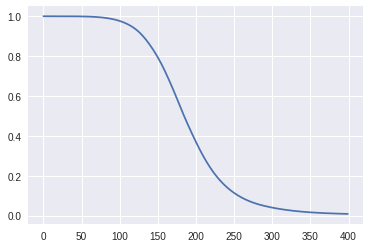

In [7]:
# Plot the probability of the target class wrt epochs
plt.plot(np.arange(0,len(prev_probs)), prev_probs)
plt.show()

In [0]:
np.save('x', x)
np.save('x_adv', x_adv)